In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36621")
client

<Client: 'tcp://127.0.0.1:36621' processes=5 threads=5, memory=14.65 GiB>

In [2]:
import numpy as np
import xarray as xr
import gcm_filters
import s3fs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/eNATL60/"
enatl60_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True)
    for ds in ["Region01/surface_hourly/fma"]
}
enatl60_datasets

{'Region01/surface_hourly/fma': <xarray.Dataset>
 Dimensions:        (time_counter: 2136, x: 611, y: 763)
 Coordinates: (12/15)
     depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
     e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
     e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
     e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
     e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
     e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
     ...             ...
     lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
     lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
     nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
     nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarra

In [7]:
ds = enatl60_datasets['Region01/surface_hourly/fma']
ds

<xarray.Dataset>
Dimensions:        (time_counter: 2136, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

In [8]:
filter_scale = 50000   # 50 km

In [9]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

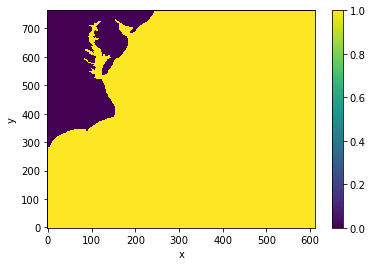

In [10]:
pad = 1
mask = np.zeros((len(ds.y)+int(2*pad),len(ds.x)+int(2*pad)))
mask[pad:-pad,pad:-pad] = ds.tmask.data
wet_mask = xr.DataArray(mask, dims=['y','x'],
                        coords={'y':np.arange(-pad,len(ds.y)+pad),
                                'x':np.arange(-pad,len(ds.x)+pad)}
                       )
wet_mask.plot()

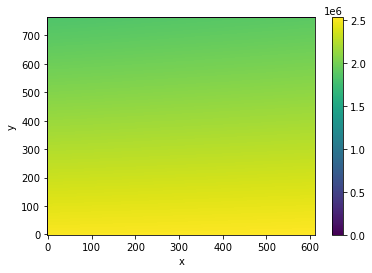

In [30]:
area = wet_mask.copy()
area[pad:-pad,pad:-pad] = ds.e1t * ds.e2t
area.plot()

In [31]:
dxw = wet_mask.copy() * np.nan
dxw[pad:-pad,pad:-pad] = ds.e1u.where(ds.umask!=0.) # x-spacing centered at western cell edge
dyw = wet_mask.copy() * np.nan
dyw[pad:-pad,pad:-pad] = ds.e2u.where(ds.umask!=0.) # y-spacing centered at western cell edge
dxs = wet_mask.copy() * np.nan
dxs[pad:-pad,pad:-pad] = ds.e1v.where(ds.vmask!=0.) # x-spacing centered at southern cell edge
dys = wet_mask.copy() * np.nan
dys[pad:-pad,pad:-pad] = ds.e2v.where(ds.vmask!=0.) # y-spacing centered at southern cell edge

In [9]:
dx_min = min(ds.e1u.min(skipna=True), ds.e2u.min(skipna=True),
             ds.e1v.min(skipna=True), ds.e2v.min(skipna=True)
            )
dx_min = dx_min.values
dx_min

array(1289.18071484)

In [40]:
kappa_w = xr.ones_like(wet_mask) * np.nan
kappa_w[pad:-pad,pad:-pad] = 1.
kappa_s = xr.ones_like(wet_mask) * np.nan
kappa_s[pad:-pad,pad:-pad] = 1.

In [41]:
filter_50km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)
filter_50km

Filter(filter_scale=50000, dx_min=array(1289.18071484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=43, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

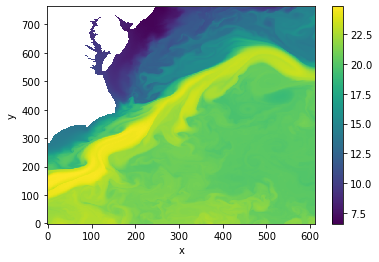

In [42]:
sst = wet_mask.copy()[pad:-pad,pad:-pad]
sst[:] = ds.sosstsst.isel(time_counter=0)
sst = sst.interp(y=wet_mask.y, x=wet_mask.x, 
                 kwargs={"fill_value": np.nan}
                )
sst.plot()
SST_filtered_to_50km = filter_50km.apply(sst, dims=['y', 'x'])

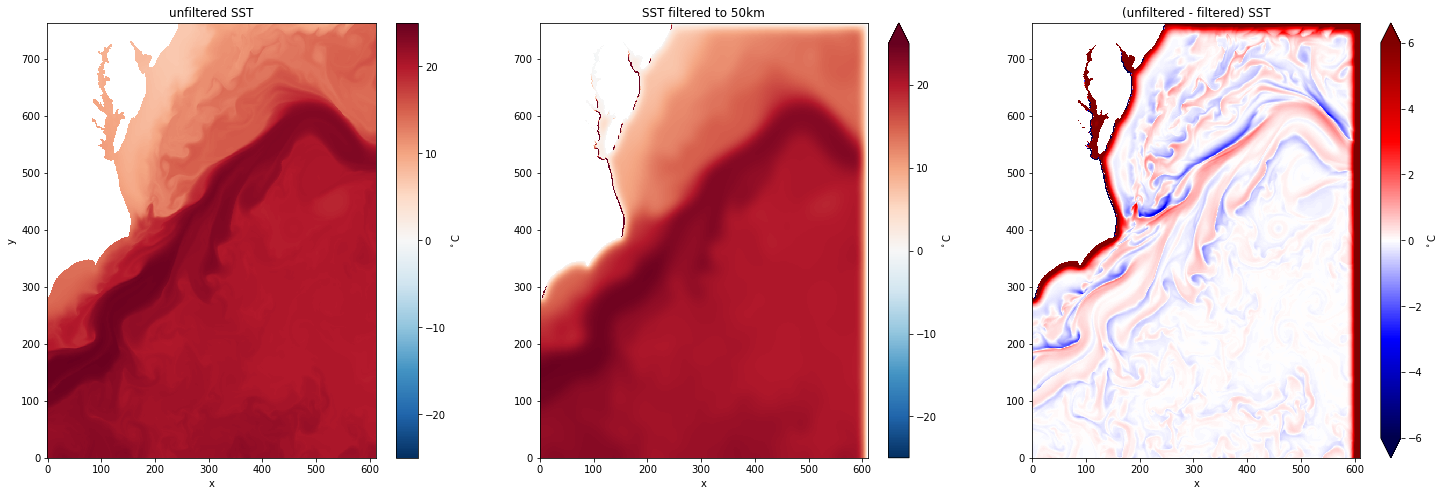

In [43]:
vmin = -25
vmax = 25

fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.sosstsst.isel(time_counter=0,y=slice(None,None),x=slice(None,None)).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[0].set(title='unfiltered SST')

SST_filtered_to_50km.isel(y=slice(pad,-pad),x=slice(pad,-pad)).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[1].set(title='SST filtered to 50km', ylabel='')

(ds.sosstsst.isel(time_counter=0) 
 - SST_filtered_to_50km.isel(y=slice(pad,-pad),x=slice(pad,-pad))
).isel(y=slice(None,None),x=slice(None,None)).plot(
    ax=axs[2], 
    vmax=6, vmin=-6,
    cmap='seismic', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[2].set(title='(unfiltered - filtered) SST', ylabel='');